# Setup

In [2]:
import os

import duckdb
import pandas as pd
import matplotlib.pyplot as plt

from dotenv import load_dotenv

plt.style.use("ggplot")
plt.rcParams.update({
    "font.size": 8,
    "figure.figsize": (5, 3),
})

%matplotlib inline

## Environment variables

In [3]:
load_dotenv()

True

## PostgreSQL configurations

In [4]:
pg_user = os.getenv("PGUSER")
pg_password = os.getenv("PGPASSWORD")
pg_host = os.getenv("PGHOST", "localhost")
pg_port = os.getenv("PGPORT", "5432")
pg_database = os.getenv("PGDATABASE")

pg_conn_str = f"postgresql://{pg_user}:{pg_password}@{pg_host}:{pg_port}/{pg_database}"

## MinIO configurations

In [5]:
s3_endpoint = "http://localhost:9000"
s3_region = "us-east-1"
s3_access_key_id = os.getenv("MINIO_ROOT_USER", "admin")
s3_secret_access_key = os.getenv("MINIO_ROOT_PASSWORD", "admin")

# Analytics and time series

## pg_mooncake

The storage layer of `pg_mooncake` is Delta Lake, so we should be able to access the tables externally.

### Retrieve storage path

In [6]:
table_path = pd.read_sql_query(
    sql="""
        SELECT path
        FROM mooncake.columnstore_tables
        WHERE table_name = 'youtube'
    """,
    con=pg_conn_str,
).loc[0, "path"]

table_path

's3://lakehouse/mooncake_datalabtech_youtube_102466/'

### Load using DuckDB

After setting up the secret to connect to MinIO, we attempt to count the number of rows in the `youtube` table.

In [7]:
con = duckdb.connect()

con.install_extension("httpfs")
con.load_extension("httpfs")

con.execute(
    f"""
    CREATE SECRET (
      TYPE S3,
      KEY_ID '{s3_access_key_id}',
      SECRET '{s3_secret_access_key}',
      ENDPOINT '{s3_endpoint.lstrip("http://")}',
      REGION '{s3_region}',
      USE_SSL false,
      URL_STYLE 'path'
    )
    """
)

result = con.execute("SELECT count(*) FROM delta_scan(?)", (table_path,)).fetchone()
print(result)

con.close()

(1541128,)


## timescaledb_toolkit

In [8]:
pd.read_sql_query(sql="SELECT count(*) FROM youtube_ts", con=pg_conn_str)

,count
0,1541128


### Hyperfunctions

In [9]:
weekly_smoothed_comments = pd.read_sql_query(sql=f"""
        SELECT week_start, orig_comments, lttb_comments, asap_comments
        FROM weekly_smoothed_comments()
        ORDER BY week_start
    """,
    con=pg_conn_str,
    parse_dates=["week_start"],
)

weekly_smoothed_comments.head(5)

,week_start,orig_comments,lttb_comments,asap_comments
0,2019-04-15,1275758934,824283407,100904100
1,2019-04-22,1039483232,447908276,32548456
2,2019-04-29,287326723,130516226,46244640
3,2019-05-06,311853342,88961496,51322095
4,2019-05-13,345296817,95201851,55042041


The plot below shows that LTTB (Largest Triangle Three Buckets), a method for downsampling, does a good job capturing the trend but not the magnitude. On the other hand, ASAP (Automatic Smoothing for Attention Prioritization), a method for smoothing, not only seems to downsample, but it also does a poor job of capturing the trend.

<Axes: title={'center': 'Original vs downsampled no. comments'}, xlabel='week_start'>

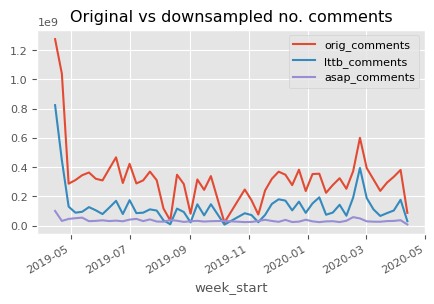

In [10]:
weekly_smoothed_comments.plot(
    title="Original vs downsampled no. comments",
    x="week_start"
)

### Dislikes distributions

In [12]:
week_start = '2020-01-06'

weekly_dislikes = pd.read_sql_query(sql=f"""
        SELECT dislikes, norm_dislikes
        FROM youtube_ts
        WHERE date_trunc('week', "timestamp")::date = '{week_start}'
    """,
    con=pg_conn_str,
)

weekly_dislikes

,dislikes,norm_dislikes
0,490,-0.687471
1,16301,1.794950
2,2711,0.691599
3,176040,2.856531
4,34229,2.168816
...,...,...
33000,3782,0.920194
33001,507,-0.656286
33002,171,-1.733900
33003,22529,1.963322


#### Original value

<Axes: title={'center': 'Dislikes for the week starting on 2020-01-06 (log-y)'}, ylabel='Frequency'>

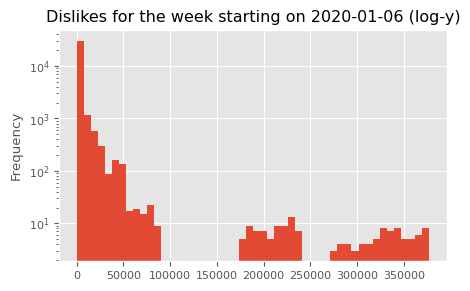

In [13]:
weekly_dislikes["dislikes"].plot.hist(
    title="Dislikes for the week starting on 2020-01-06 (log-y)",
    bins=50,
    logy=True,
)

#### Transformed value

<Axes: title={'center': 'Normalized dislikes for the week starting on 2020-01-06'}, ylabel='Frequency'>

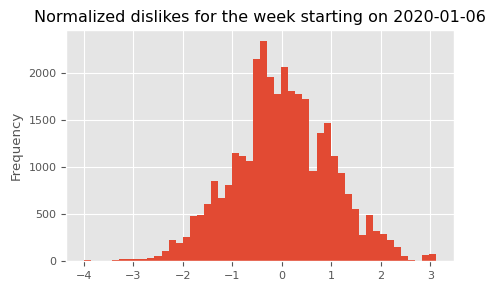

In [14]:
weekly_dislikes["norm_dislikes"].plot.hist(
    title="Normalized dislikes for the week starting on 2020-01-06",
    bins=50,
)